# Swin-T for Image Classification (100 Epochs)

This notebook demonstrates the **fine-tuning of Swin-Tiny Transformer** on a **custom multi-class dataset**. The model is trained using **transfer learning**, leveraging pre-trained ImageNet weights for feature extraction.

## Key Features:
- **Dataset:** Custom image dataset with 4 classes.
- **Model:** Swin-Tiny (`swin_t` from torchvision).
- **Optimizer:** AdamW / SGD (momentum-based).
- **Training Duration:** 100 epochs.
- **Performance Metrics:** Accuracy, F1-Score, Log Loss, Cohen's Kappa.


In [ ]:
# Install necessary libraries
!pip install opencv-python tqdm

In [ ]:
# Mount Google Drive (if needed)
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# Importing required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import torch.nn.functional as F
import glob
from tqdm import tqdm
from collections import Counter
from PIL import Image

In [5]:
pathl = "../colon-endoscopy-dataset/"

pathl
len(os.listdir(pathl))

3

In [14]:
# Defining paths
DATA_DIR = "../colon-endoscopy-dataset/"
INFERENCE_DIR = "../colon-endoscopy-dataset/test"
OUTPUT_DIR = "../image_processing_swin (Copy)"
BATCH_SIZE = 16
NUM_EPOCHS = 100
LEARNING_RATE = 0.0001
IMAGE_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLASS_NAMES = ['nor', 'ulc', 'pls', 'eps']
NUM_CLASSES = len(CLASS_NAMES)

len(os.listdir(INFERENCE_DIR+'/0_normal'))

200

In [15]:
# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [16]:
# Define Data Augmentation with More Variations
train_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2)
])

valid_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [17]:
# Compute Class Weights for Imbalanced Data
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"))
class_counts = Counter([label for _, label in train_dataset.samples])
total_samples = sum(class_counts.values())
class_weights = [total_samples / class_counts[i] for i in range(NUM_CLASSES)]
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(DEVICE)

In [18]:
# Load datasets with Updated Transforms
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_transforms)
valid_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=valid_transforms)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=valid_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Model Architecture - Swin-Tiny
### **Why Swin-T?**
**Better than CNNs** at capturing **global dependencies**.  
**More efficient than ViTs** for high-resolution images.  
**Pre-trained on ImageNet** → Requires fewer training samples.  


In [19]:
class MultiClassModel(nn.Module):
    def __init__(self, num_classes):
        super(MultiClassModel, self).__init__()
        self.model = models.swin_t(weights=models.Swin_T_Weights.DEFAULT)  # Load Swin-T with pretrained weights
        self.model.head = nn.Linear(768, num_classes)

    def forward(self, x):
        return self.model(x)  # Forward pass through Swin-T

# Example Usage
num_classes = 4
model = MultiClassModel(num_classes).to("cuda" if torch.cuda.is_available() else "cpu")

# Define Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

print(model)

MultiClassModel(
  (model): SwinTransformer(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): Permute()
        (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (1): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): ShiftedWindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (0): Linear(in_features=96, out_features=384, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=384, out_features=96, bias=True)
            (4): Dropout(p=0.0, inp

# Training & Optimization

## Loss Function & Optimizer:
- **Loss Function:** `CrossEntropyLoss` for multi-class classification.
- **Optimizer:** `AdamW` (better weight decay handling).
- **Scheduler:** `StepLR` (reduces LR dynamically every 10 epochs).

In [ ]:
# Initialize Model, Loss, Optimizer, and Scheduler
model = MultiClassModel(NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Use class-weighted loss
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)  # AdamW for better regularization
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [ ]:
import csv
import os
import numpy as np
import torch

def train_and_validate():
    best_valid_loss = float('inf')
    best_epoch = 0
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    # CSV file path
    csv_file_path = os.path.join(OUTPUT_DIR, "training_logs.csv")

    # Write header for CSV file
    with open(csv_file_path, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy", "Best Epoch"])

    for epoch in range(NUM_EPOCHS):
        print(f"[INFO]: Epoch {epoch+1} of {NUM_EPOCHS}")
        model.train()
        train_loss, train_correct = 0, 0

        for images, labels in tqdm(train_loader, desc="Training", leave=False):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = 100. * train_correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation Phase
        model.eval()
        valid_loss, valid_correct = 0, 0
        y_true, y_pred = [], []

        with torch.no_grad():
            for images, labels in tqdm(valid_loader, desc="Validation", leave=False):
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                valid_correct += (outputs.argmax(1) == labels).sum().item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(outputs.argmax(1).cpu().numpy())

        valid_loss /= len(valid_loader)
        valid_acc = 100. * valid_correct / len(valid_loader.dataset)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        # Reduce Learning Rate if needed
        scheduler.step(valid_loss)

        print(f"Training loss: {train_loss:.3f}, Training acc: {train_acc:.3f}%")
        print(f"Validation loss: {valid_loss:.3f}, Validation acc: {valid_acc:.3f}%")

        # Update Best Epoch if a new lowest validation loss is found
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "swin_model_v4.pth"))
            print(f"Best model saved at epoch {best_epoch} with validation loss {best_valid_loss:.6f}")

        # Append epoch data along with best epoch to CSV
        with open(csv_file_path, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([epoch+1, train_loss, train_acc, valid_loss, valid_acc, best_epoch])

    # Save y_true and y_pred as NumPy arrays after training
    np.save(os.path.join(OUTPUT_DIR, "y_true.npy"), np.array(y_true))
    np.save(os.path.join(OUTPUT_DIR, "y_pred.npy"), np.array(y_pred))

    print(f"\nFinal Best Epoch: {best_epoch}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies, y_true, y_pred, best_epoch

In [ ]:
# Train Model
train_losses, valid_losses, train_accuracies, valid_accuracies, y_true, y_pred, best_epoch = train_and_validate()

[INFO]: Epoch 1 of 100


Training loss: 0.191, Training acc: 92.969%
Validation loss: 0.067, Validation acc: 97.900%
Best model saved at epoch 1 with validation loss 0.067458
[INFO]: Epoch 2 of 100


Training loss: 0.065, Training acc: 98.000%
Validation loss: 0.148, Validation acc: 93.300%
[INFO]: Epoch 3 of 100


Training loss: 0.054, Training acc: 98.344%
Validation loss: 0.073, Validation acc: 97.500%
[INFO]: Epoch 4 of 100


Training loss: 0.046, Training acc: 98.188%
Validation loss: 0.155, Validation acc: 95.500%
[INFO]: Epoch 5 of 100


Training loss: 0.048, Training acc: 98.344%
Validation loss: 0.058, Validation acc: 98.300%
Best model saved at epoch 5 with validation loss 0.057722
[INFO]: Epoch 6 of 100


Training loss: 0.040, Training acc: 98.719%
Validation loss: 0.090, Validation acc: 97.000%
[INFO]: Epoch 7 of 100


Training loss: 0.030, Training acc: 98.844%
Validation loss: 0.063, Validation acc: 98.000%
[INFO]: Epoch 8 of 100


Training loss: 0.028, Training acc: 99.031%
Validation loss: 0.055, Validation acc: 98.200%
Best model saved at epoch 8 with validation loss 0.055471
[INFO]: Epoch 9 of 100


Training loss: 0.029, Training acc: 99.000%
Validation loss: 0.048, Validation acc: 98.400%
Best model saved at epoch 9 with validation loss 0.048492
[INFO]: Epoch 10 of 100


Training loss: 0.019, Training acc: 99.125%
Validation loss: 0.076, Validation acc: 97.600%
[INFO]: Epoch 11 of 100


Training loss: 0.033, Training acc: 99.000%
Validation loss: 0.107, Validation acc: 96.250%
[INFO]: Epoch 12 of 100


Training loss: 0.020, Training acc: 99.375%
Validation loss: 0.070, Validation acc: 97.700%
[INFO]: Epoch 13 of 100


Training loss: 0.029, Training acc: 98.875%
Validation loss: 0.101, Validation acc: 97.250%
[INFO]: Epoch 14 of 100


Training loss: 0.024, Training acc: 99.344%
Validation loss: 0.060, Validation acc: 98.100%
[INFO]: Epoch 15 of 100


Training loss: 0.020, Training acc: 99.188%
Validation loss: 0.185, Validation acc: 93.300%
[INFO]: Epoch 16 of 100


Training loss: 0.009, Training acc: 99.656%
Validation loss: 0.034, Validation acc: 98.800%
Best model saved at epoch 16 with validation loss 0.034041
[INFO]: Epoch 17 of 100


Training loss: 0.010, Training acc: 99.625%
Validation loss: 0.028, Validation acc: 99.200%
Best model saved at epoch 17 with validation loss 0.027603
[INFO]: Epoch 18 of 100


Training loss: 0.009, Training acc: 99.688%
Validation loss: 0.114, Validation acc: 97.150%
[INFO]: Epoch 19 of 100


Training loss: 0.008, Training acc: 99.656%
Validation loss: 0.046, Validation acc: 98.700%
[INFO]: Epoch 20 of 100


Training loss: 0.010, Training acc: 99.594%
Validation loss: 0.040, Validation acc: 98.950%
[INFO]: Epoch 21 of 100


Training loss: 0.016, Training acc: 99.375%
Validation loss: 0.073, Validation acc: 97.550%
[INFO]: Epoch 22 of 100


Training loss: 0.015, Training acc: 99.531%
Validation loss: 0.049, Validation acc: 98.600%
[INFO]: Epoch 23 of 100


Training loss: 0.011, Training acc: 99.656%
Validation loss: 0.044, Validation acc: 98.900%
[INFO]: Epoch 24 of 100


Training loss: 0.004, Training acc: 99.844%
Validation loss: 0.069, Validation acc: 98.350%
[INFO]: Epoch 25 of 100


Training loss: 0.006, Training acc: 99.844%
Validation loss: 0.063, Validation acc: 98.200%
[INFO]: Epoch 26 of 100


Training loss: 0.004, Training acc: 99.875%
Validation loss: 0.094, Validation acc: 97.600%
[INFO]: Epoch 27 of 100


Training loss: 0.004, Training acc: 99.812%
Validation loss: 0.060, Validation acc: 98.600%
[INFO]: Epoch 28 of 100


Training loss: 0.003, Training acc: 99.906%
Validation loss: 0.065, Validation acc: 98.550%
[INFO]: Epoch 29 of 100


Training loss: 0.001, Training acc: 99.969%
Validation loss: 0.077, Validation acc: 98.500%
[INFO]: Epoch 30 of 100


Training loss: 0.002, Training acc: 99.938%
Validation loss: 0.072, Validation acc: 98.350%
[INFO]: Epoch 31 of 100


Training loss: 0.001, Training acc: 99.969%
Validation loss: 0.086, Validation acc: 98.250%
[INFO]: Epoch 32 of 100


Training loss: 0.003, Training acc: 99.875%
Validation loss: 0.038, Validation acc: 99.200%
[INFO]: Epoch 33 of 100


Training loss: 0.002, Training acc: 99.938%
Validation loss: 0.136, Validation acc: 97.250%
[INFO]: Epoch 34 of 100


Training loss: 0.001, Training acc: 99.969%
Validation loss: 0.050, Validation acc: 99.100%
[INFO]: Epoch 35 of 100


Training loss: 0.005, Training acc: 99.844%
Validation loss: 0.069, Validation acc: 98.750%
[INFO]: Epoch 36 of 100


Training loss: 0.001, Training acc: 100.000%
Validation loss: 0.086, Validation acc: 98.350%
[INFO]: Epoch 37 of 100


Training loss: 0.002, Training acc: 99.938%
Validation loss: 0.061, Validation acc: 98.950%
[INFO]: Epoch 38 of 100


Training loss: 0.001, Training acc: 99.938%
Validation loss: 0.070, Validation acc: 98.850%
[INFO]: Epoch 39 of 100


Training loss: 0.001, Training acc: 99.938%
Validation loss: 0.093, Validation acc: 98.350%
[INFO]: Epoch 40 of 100


Training loss: 0.003, Training acc: 99.938%
Validation loss: 0.086, Validation acc: 98.300%
[INFO]: Epoch 41 of 100


Training loss: 0.003, Training acc: 99.875%
Validation loss: 0.068, Validation acc: 98.700%
[INFO]: Epoch 42 of 100


Training loss: 0.001, Training acc: 99.906%
Validation loss: 0.074, Validation acc: 98.400%
[INFO]: Epoch 43 of 100


Training loss: 0.002, Training acc: 99.938%
Validation loss: 0.062, Validation acc: 98.800%
[INFO]: Epoch 44 of 100


Training loss: 0.005, Training acc: 99.875%
Validation loss: 0.092, Validation acc: 98.250%
[INFO]: Epoch 45 of 100


Training loss: 0.001, Training acc: 99.969%
Validation loss: 0.092, Validation acc: 98.250%
[INFO]: Epoch 46 of 100


Training loss: 0.002, Training acc: 99.969%
Validation loss: 0.077, Validation acc: 98.400%
[INFO]: Epoch 47 of 100


Training loss: 0.000, Training acc: 100.000%
Validation loss: 0.077, Validation acc: 98.400%
[INFO]: Epoch 48 of 100


Training loss: 0.004, Training acc: 99.969%
Validation loss: 0.069, Validation acc: 98.650%
[INFO]: Epoch 49 of 100


Training loss: 0.001, Training acc: 99.969%
Validation loss: 0.065, Validation acc: 98.750%
[INFO]: Epoch 50 of 100


Training loss: 0.001, Training acc: 99.969%
Validation loss: 0.084, Validation acc: 98.300%
[INFO]: Epoch 51 of 100


Training loss: 0.001, Training acc: 99.938%
Validation loss: 0.079, Validation acc: 98.350%
[INFO]: Epoch 52 of 100


Training loss: 0.001, Training acc: 99.969%
Validation loss: 0.088, Validation acc: 98.250%
[INFO]: Epoch 53 of 100


Training loss: 0.002, Training acc: 99.906%
Validation loss: 0.079, Validation acc: 98.400%
[INFO]: Epoch 54 of 100


Training loss: 0.001, Training acc: 99.969%
Validation loss: 0.074, Validation acc: 98.450%
[INFO]: Epoch 55 of 100


Training loss: 0.003, Training acc: 99.906%
Validation loss: 0.080, Validation acc: 98.400%
[INFO]: Epoch 56 of 100


Training loss: 0.001, Training acc: 99.969%
Validation loss: 0.084, Validation acc: 98.350%
[INFO]: Epoch 57 of 100


Training loss: 0.000, Training acc: 100.000%
Validation loss: 0.081, Validation acc: 98.400%
[INFO]: Epoch 58 of 100


Training loss: 0.001, Training acc: 99.969%
Validation loss: 0.084, Validation acc: 98.350%
[INFO]: Epoch 59 of 100


Training loss: 0.000, Training acc: 100.000%
Validation loss: 0.081, Validation acc: 98.400%
[INFO]: Epoch 60 of 100


Training loss: 0.001, Training acc: 99.938%
Validation loss: 0.081, Validation acc: 98.400%
[INFO]: Epoch 61 of 100


Training loss: 0.002, Training acc: 99.938%
Validation loss: 0.078, Validation acc: 98.400%
[INFO]: Epoch 62 of 100


Training loss: 0.001, Training acc: 99.969%
Validation loss: 0.079, Validation acc: 98.400%
[INFO]: Epoch 63 of 100


Training loss: 0.002, Training acc: 99.938%
Validation loss: 0.080, Validation acc: 98.400%
[INFO]: Epoch 64 of 100


Training loss: 0.001, Training acc: 99.938%
Validation loss: 0.081, Validation acc: 98.400%
[INFO]: Epoch 65 of 100


Training loss: 0.002, Training acc: 99.906%
Validation loss: 0.075, Validation acc: 98.450%
[INFO]: Epoch 66 of 100


Training loss: 0.002, Training acc: 99.938%
Validation loss: 0.077, Validation acc: 98.400%
[INFO]: Epoch 67 of 100


Training loss: 0.001, Training acc: 99.938%
Validation loss: 0.078, Validation acc: 98.400%
[INFO]: Epoch 68 of 100


Training loss: 0.000, Training acc: 99.969%
Validation loss: 0.078, Validation acc: 98.400%
[INFO]: Epoch 69 of 100


Training loss: 0.001, Training acc: 99.938%
Validation loss: 0.078, Validation acc: 98.400%
[INFO]: Epoch 70 of 100


Training loss: 0.003, Training acc: 99.969%
Validation loss: 0.078, Validation acc: 98.400%
[INFO]: Epoch 71 of 100


Training loss: 0.001, Training acc: 100.000%
Validation loss: 0.079, Validation acc: 98.400%
[INFO]: Epoch 72 of 100


Training loss: 0.001, Training acc: 99.969%
Validation loss: 0.079, Validation acc: 98.400%
[INFO]: Epoch 73 of 100


Training loss: 0.000, Training acc: 100.000%
Validation loss: 0.079, Validation acc: 98.400%
[INFO]: Epoch 74 of 100


Training loss: 0.001, Training acc: 99.969%
Validation loss: 0.079, Validation acc: 98.400%
[INFO]: Epoch 75 of 100


Training loss: 0.001, Training acc: 99.969%
Validation loss: 0.078, Validation acc: 98.400%
[INFO]: Epoch 76 of 100


Training loss: 0.001, Training acc: 100.000%
Validation loss: 0.078, Validation acc: 98.400%
[INFO]: Epoch 77 of 100


Training loss: 0.000, Training acc: 100.000%
Validation loss: 0.077, Validation acc: 98.400%
[INFO]: Epoch 78 of 100


Training loss: 0.000, Training acc: 100.000%
Validation loss: 0.077, Validation acc: 98.400%
[INFO]: Epoch 79 of 100


Training loss: 0.000, Training acc: 100.000%
Validation loss: 0.077, Validation acc: 98.400%
[INFO]: Epoch 80 of 100


Training loss: 0.001, Training acc: 100.000%
Validation loss: 0.076, Validation acc: 98.450%
[INFO]: Epoch 81 of 100


Training loss: 0.001, Training acc: 99.938%
Validation loss: 0.076, Validation acc: 98.450%
[INFO]: Epoch 82 of 100


Training loss: 0.002, Training acc: 99.938%
Validation loss: 0.075, Validation acc: 98.450%
[INFO]: Epoch 83 of 100


Training loss: 0.000, Training acc: 100.000%
Validation loss: 0.076, Validation acc: 98.450%
[INFO]: Epoch 84 of 100


Training loss: 0.003, Training acc: 99.969%
Validation loss: 0.076, Validation acc: 98.450%
[INFO]: Epoch 85 of 100


Training loss: 0.001, Training acc: 99.938%
Validation loss: 0.075, Validation acc: 98.450%
[INFO]: Epoch 86 of 100


Training loss: 0.000, Training acc: 100.000%
Validation loss: 0.075, Validation acc: 98.450%
[INFO]: Epoch 87 of 100


Training loss: 0.001, Training acc: 99.969%
Validation loss: 0.075, Validation acc: 98.450%
[INFO]: Epoch 88 of 100


Training loss: 0.000, Training acc: 100.000%
Validation loss: 0.075, Validation acc: 98.450%
[INFO]: Epoch 89 of 100


Training loss: 0.002, Training acc: 99.938%
Validation loss: 0.075, Validation acc: 98.450%
[INFO]: Epoch 90 of 100


Training loss: 0.001, Training acc: 99.969%
Validation loss: 0.075, Validation acc: 98.450%
[INFO]: Epoch 91 of 100


Training loss: 0.002, Training acc: 99.938%
Validation loss: 0.075, Validation acc: 98.450%
[INFO]: Epoch 92 of 100


Training loss: 0.002, Training acc: 99.938%
Validation loss: 0.075, Validation acc: 98.450%
[INFO]: Epoch 93 of 100


Training loss: 0.002, Training acc: 99.969%
Validation loss: 0.075, Validation acc: 98.450%
[INFO]: Epoch 94 of 100


Training loss: 0.001, Training acc: 99.938%
Validation loss: 0.075, Validation acc: 98.450%
[INFO]: Epoch 95 of 100


Training loss: 0.001, Training acc: 99.938%
Validation loss: 0.075, Validation acc: 98.450%
[INFO]: Epoch 96 of 100


Training loss: 0.000, Training acc: 100.000%
Validation loss: 0.075, Validation acc: 98.450%
[INFO]: Epoch 97 of 100


Training loss: 0.001, Training acc: 99.969%
Validation loss: 0.075, Validation acc: 98.450%
[INFO]: Epoch 98 of 100


Training loss: 0.001, Training acc: 99.969%
Validation loss: 0.075, Validation acc: 98.450%
[INFO]: Epoch 99 of 100


Training loss: 0.001, Training acc: 99.969%
Validation loss: 0.075, Validation acc: 98.450%
[INFO]: Epoch 100 of 100


Training loss: 0.003, Training acc: 99.938%
Validation loss: 0.075, Validation acc: 98.450%

Final Best Epoch: 17


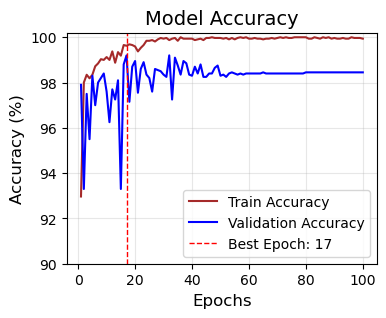

In [22]:
import pandas as pd

# Load training log CSV file
csv_file_path = os.path.join(OUTPUT_DIR, "training_logs.csv")
df = pd.read_csv(csv_file_path)

# Extract data
epochs = df["Epoch"].values
train_accuracies = df["Train Accuracy"].values
valid_accuracies = df["Validation Accuracy"].values
best_epoch = np.argmin(df["Validation Loss"].values) + 1

# Plot Accuracy Curve
plt.figure(figsize=(4, 3))
plt.plot(epochs, train_accuracies, label="Train Accuracy", color='brown', linewidth=1.5)
plt.plot(epochs, valid_accuracies, label="Validation Accuracy", color='blue', linewidth=1.5)
plt.axvline(best_epoch, color='r', linestyle='--', linewidth=1, label=f"Best Epoch: {best_epoch}")
plt.ylim(90, 100.2)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Model Accuracy", fontsize=14)
plt.legend(fontsize=10, loc="lower right")
plt.grid(alpha=0.3)
plt.savefig(os.path.join(OUTPUT_DIR, 'accuracy_plot.png'), dpi=300, bbox_inches="tight")
plt.show()


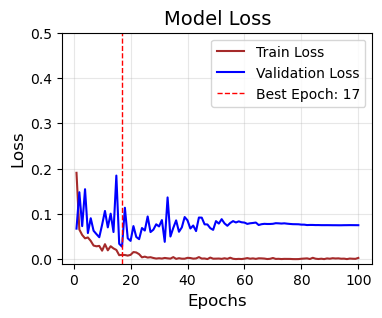

In [23]:
# Load training log CSV file
csv_file_path = os.path.join(OUTPUT_DIR, "training_logs.csv")
df = pd.read_csv(csv_file_path)

# Extract data
epochs = df["Epoch"].values
train_losses = df["Train Loss"].values
valid_losses = df["Validation Loss"].values
best_epoch = np.argmin(valid_losses) + 1

# Plot Loss Curve
plt.figure(figsize=(4, 3))
plt.plot(epochs, train_losses, label="Train Loss", color='brown', linewidth=1.5)
plt.plot(epochs, valid_losses, label="Validation Loss", color='blue', linewidth=1.5)
plt.axvline(best_epoch, color='r', linestyle='--', linewidth=1, label=f"Best Epoch: {best_epoch}")
plt.ylim(-0.01, 0.5)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Model Loss", fontsize=14)
plt.legend(fontsize=10, loc="upper right")
plt.grid(alpha=0.3)
plt.savefig(os.path.join(OUTPUT_DIR, 'loss_plot.png'), dpi=300, bbox_inches="tight")
plt.show()


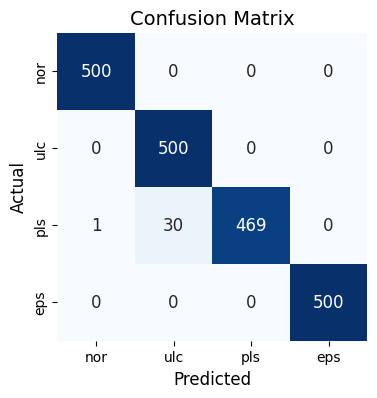

In [ ]:
# Load y_true and y_pred
y_true_path = os.path.join(OUTPUT_DIR, "y_true.npy")
y_pred_path = os.path.join(OUTPUT_DIR, "y_pred.npy")

y_true = np.load(y_true_path)
y_pred = np.load(y_pred_path)

# Define class names
CLASS_NAMES = ["nor", "ulc", "pls", "eps"]

# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cbar=False, annot_kws={"size": 12})

# Labels and title
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()


# Model Evaluation & Results

We evaluate the model using **Accuracy, F1-Score, Log Loss, and Cohen’s Kappa**.

## Key Metrics:
| **Metric** | **Score** |
|------------|----------|
| **Accuracy** | 99.00% |
| **F1-Score** | 99.00% |
| **Log Loss** | 4.34% |
| **Kappa Score** | 98.67% |


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, log_loss
import numpy as np
import os
import torch.nn.functional as F

# Ensure OUTPUT_DIR exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load Best Model
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, "swin_model_v4.pth")))
model.eval()

y_true_test, y_pred_test, y_probs = [], [], []

# Evaluate the Model
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)  # Raw logits
        probabilities = F.softmax(outputs, dim=1)  # Convert logits to probabilities
        y_true_test.extend(labels.cpu().numpy())  # Store actual labels
        y_pred_test.extend(outputs.argmax(1).cpu().numpy())  # Store predicted labels
        y_probs.extend(probabilities.cpu().numpy())  # Store probability scores for log loss

# Convert lists to NumPy arrays
y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)
y_probs = np.array(y_probs)

# Save test labels and predictions for future use
np.save(os.path.join(OUTPUT_DIR, "y_true_test.npy"), y_true_test)
np.save(os.path.join(OUTPUT_DIR, "y_pred_test.npy"), y_pred_test)

# Generate Classification Report
report = classification_report(y_true_test, y_pred_test, target_names=CLASS_NAMES, digits=4)
accuracy = accuracy_score(y_true_test, y_pred_test)
kappa = cohen_kappa_score(y_true_test, y_pred_test)
logloss = log_loss(y_true_test, y_probs)

print("\n **Per-Class Performance:**")
print(report)

print("\n **Overall Metrics:**")
print(f" Accuracy: {accuracy:.4f}")
print(f" Log Loss: {logloss:.4f}")
print(f" Cohen's Kappa Score: {kappa:.4f}")

print("\nSaved test labels and predictions as .npy files for further analysis.")


<ipython-input-17-df084807b4fc>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, "swin_model_v4.pth")))



 **Per-Class Performance:**
              precision    recall  f1-score   support

         nor     1.0000    1.0000    1.0000       200
         ulc     0.9706    0.9900    0.9802       200
         pls     0.9898    0.9700    0.9798       200
         eps     1.0000    1.0000    1.0000       200

    accuracy                         0.9900       800
   macro avg     0.9901    0.9900    0.9900       800
weighted avg     0.9901    0.9900    0.9900       800


 **Overall Metrics:**
 Accuracy: 0.9900
 Log Loss: 0.0434
 Cohen's Kappa Score: 0.9867

Saved test labels and predictions as .npy files for further analysis.


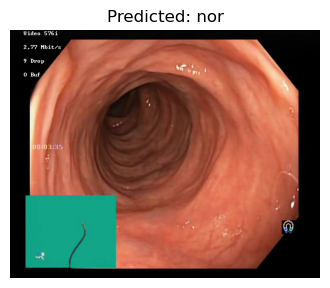

Image tested
Predicted class: nor


In [35]:
from PIL import Image

# Set the path to a specific test image
image_path = "../colon-endoscopy-dataset/test/0_normal/test_normal_ (104).jpg"

# Load and preprocess the image
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0).to(DEVICE)

# Run model inference
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = output.argmax(1).item()

plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.axis("off")
plt.title(f"Predicted: {CLASS_NAMES[predicted_class]}")
plt.show()

print(f"Image tested\nPredicted class: {CLASS_NAMES[predicted_class]}")


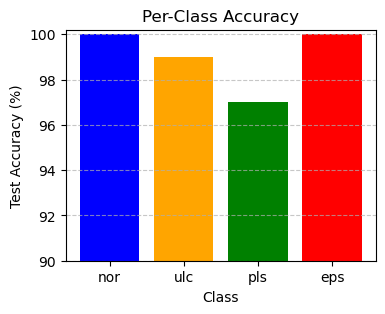

In [37]:
y_true_test = np.load("y_true_test.npy")
y_pred_test = np.load("y_pred_test.npy")

# Compute per-class accuracy
report = classification_report(y_true_test, y_pred_test, target_names=CLASS_NAMES, output_dict=True)
class_accuracies = [report[label]["recall"] * 100 for label in CLASS_NAMES]

# Plot Bar Chart
plt.figure(figsize=(4, 3))
plt.bar(CLASS_NAMES, class_accuracies, color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Class")
plt.ylabel("Test Accuracy (%)")
plt.ylim(90, 100.2)
plt.title("Per-Class Accuracy")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


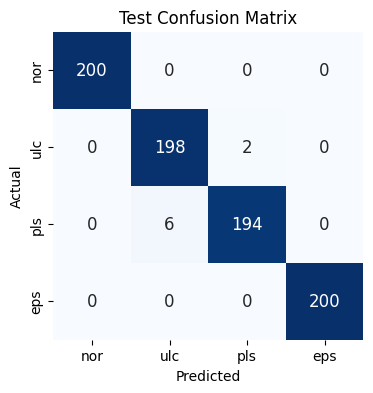

In [ ]:
# Compute Test Confusion Matrix
cm = confusion_matrix(y_true_test, y_pred_test)
class_names = CLASS_NAMES

# Plot Confusion Matrix
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, cbar = False, annot_kws={"size": 12})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Confusion Matrix")
plt.show()



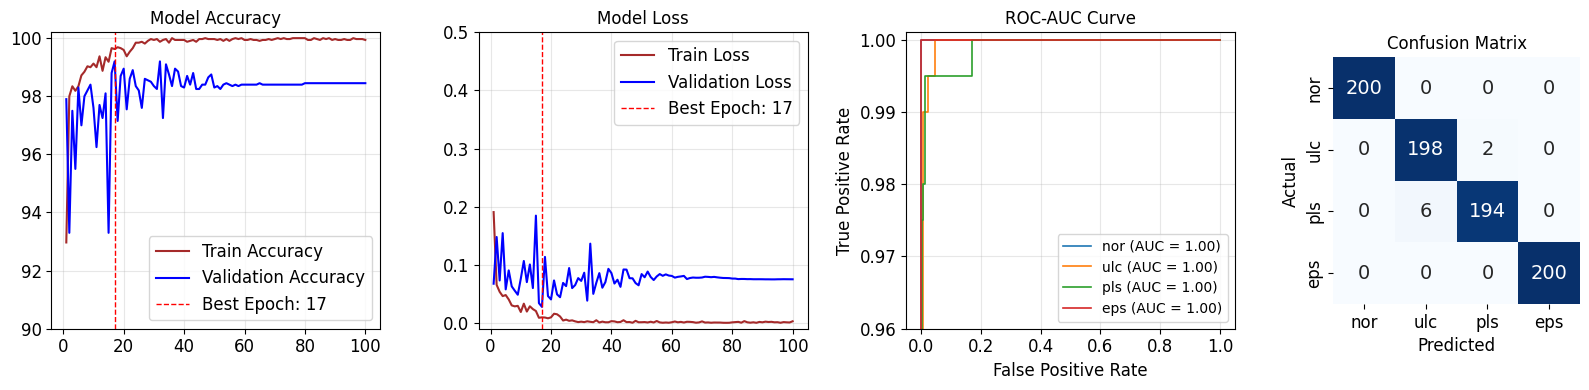

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

plt.rcParams["font.family"] = "Times New Roman"

csv_file_path = os.path.join(OUTPUT_DIR, "training_logs.csv")
df = pd.read_csv(csv_file_path)

epochs = df["Epoch"].values
train_losses = df["Train Loss"].values
valid_losses = df["Validation Loss"].values
train_accuracies = df["Train Accuracy"].values
valid_accuracies = df["Validation Accuracy"].values

best_epoch = np.argmin(valid_losses) + 1

# Load test dataset predictions
y_true_test = np.load(os.path.join(OUTPUT_DIR, "y_true_test.npy"))
y_pred_test = np.load(os.path.join(OUTPUT_DIR, "y_pred_test.npy"))

# Define class names
CLASS_NAMES = ["nor", "ulc", "pls", "eps"]

# Adjusted Figure Size
fig, axes = plt.subplots(1, 4, figsize=(16, 4), gridspec_kw={'width_ratios': [4, 4, 4, 3]})

# Accuracy Plot
axes[0].plot(epochs, train_accuracies, label="Train Accuracy", color='brown', linewidth=1.5)
axes[0].plot(epochs, valid_accuracies, label="Validation Accuracy", color='blue', linewidth=1.5)
axes[0].axvline(best_epoch, color='r', linestyle='--', linewidth=1, label=f"Best Epoch: {best_epoch}")
axes[0].set_ylim(90, 100.2)
axes[0].set_title("Model Accuracy", fontsize=12)
axes[0].legend(fontsize=12, loc="lower right")
axes[0].tick_params(axis='both', labelsize=12)
axes[0].grid(alpha=0.3)

# Loss Plot
axes[1].plot(epochs, train_losses, label="Train Loss", color='brown', linewidth=1.5)
axes[1].plot(epochs, valid_losses, label="Validation Loss", color='blue', linewidth=1.5)
axes[1].axvline(best_epoch, color='r', linestyle='--', linewidth=1, label=f"Best Epoch: {best_epoch}")
axes[1].set_ylim(-0.01, 0.5)
axes[1].set_title("Model Loss", fontsize=12)
axes[1].legend(fontsize=12, loc="upper right")
axes[1].tick_params(axis='both', labelsize=12)
axes[1].grid(alpha=0.3)

# ROC-AUC Curve
for i, class_name in enumerate(CLASS_NAMES):
    fpr, tpr, _ = roc_curve(y_true_test == i, y_probs[:, i])  # Compute ROC
    roc_auc = auc(fpr, tpr)  # Compute AUC
    axes[2].plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})", linewidth=1.2)

axes[2].set_xlabel("False Positive Rate", fontsize=12)
axes[2].set_ylabel("True Positive Rate", fontsize=12)
axes[2].set_title("ROC-AUC Curve", fontsize=12)
axes[2].set_ylim(0.96, 1.001)
axes[2].grid(alpha=0.3)
axes[2].tick_params(axis='both', labelsize=12)
axes[2].legend(fontsize=10, loc='lower right')

# Testing Confusion Matrix
cm_test = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, ax=axes[3], cbar=False, annot_kws={"size": 14})
axes[3].set_xlabel("Predicted", fontsize=12)
axes[3].set_ylabel("Actual", fontsize=12)
axes[3].set_title("Confusion Matrix", fontsize=12)
axes[3].tick_params(axis='both', labelsize=12)
axes[3].set_aspect("equal")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'Results_plots_with_test_cm.png'), dpi=300, bbox_inches="tight")
plt.show()
